In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
import os
import cv2

import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [3]:
seed_constant =27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

['NonViolence', 'Violence']


(-0.5, 223.5, 223.5, -0.5)

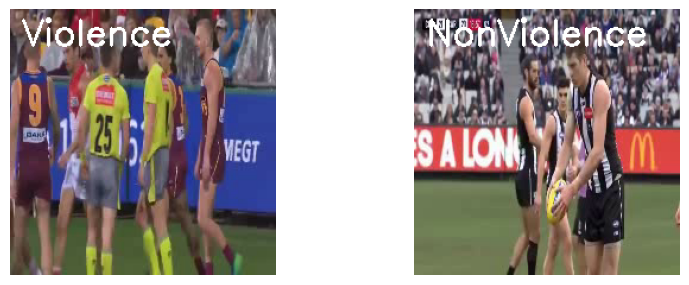

In [4]:
plt.figure(figsize=(20,20))

all_classes_name=os.listdir("/content/drive/MyDrive/m")
print(all_classes_name)
video_files_name_list1=os.listdir("/content/drive/MyDrive/m/Violence")

selected=random.choice(video_files_name_list1)
video_reader=cv2.VideoCapture(f'/content/drive/MyDrive/m/Violence/{selected}')
_, bgr_frame=video_reader.read()
video_reader.release()
rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
cv2.putText(rgb_frame,"Violence",(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
plt.subplot(5,4,1);plt.imshow(rgb_frame);plt.axis('off')

video_files_name_list2=os.listdir("/content/drive/MyDrive/m/NonViolence")

selected1=random.choice(video_files_name_list2)
video_reader1=cv2.VideoCapture(f'/content/drive/MyDrive/m/NonViolence/{selected1}')
_, bgr_frame1=video_reader1.read()
video_reader1.release()
rgb_frame1=cv2.cvtColor(bgr_frame1,cv2.COLOR_BGR2RGB)
cv2.putText(rgb_frame1,"NonViolence",(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
plt.subplot(5,4,2);plt.imshow(rgb_frame1);plt.axis('off')

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH =64, 64

SEQUENCE_LENGTH=10

DATASET_DIR="/content/drive/MyDrive/m"
CLASSES_LIST=["Violence","NonViolence"]

In [6]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader= cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
                # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

         # Release the VideoCapture object.
    video_reader.release()

         # Return the frames list.
    return frames_list

In [7]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

# Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

            # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths


In [8]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Violence
Extracting Data of Class: NonViolence


In [11]:

one_hot_encoded_labels = to_categorical(labels)
print(len(one_hot_encoded_labels))

2000


In [12]:
print("Hello")
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

Hello


In [13]:
print("Hello")
def create_LRCN_model():

    model=Sequential()
    model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=
                             (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4,4))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST),activation='softmax'))

    model.summary()

    return model

Hello


In [14]:
print("Hello")
LRCN_model=create_LRCN_model()
print("Model created successfully!")

Hello
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 4, 4, 32)

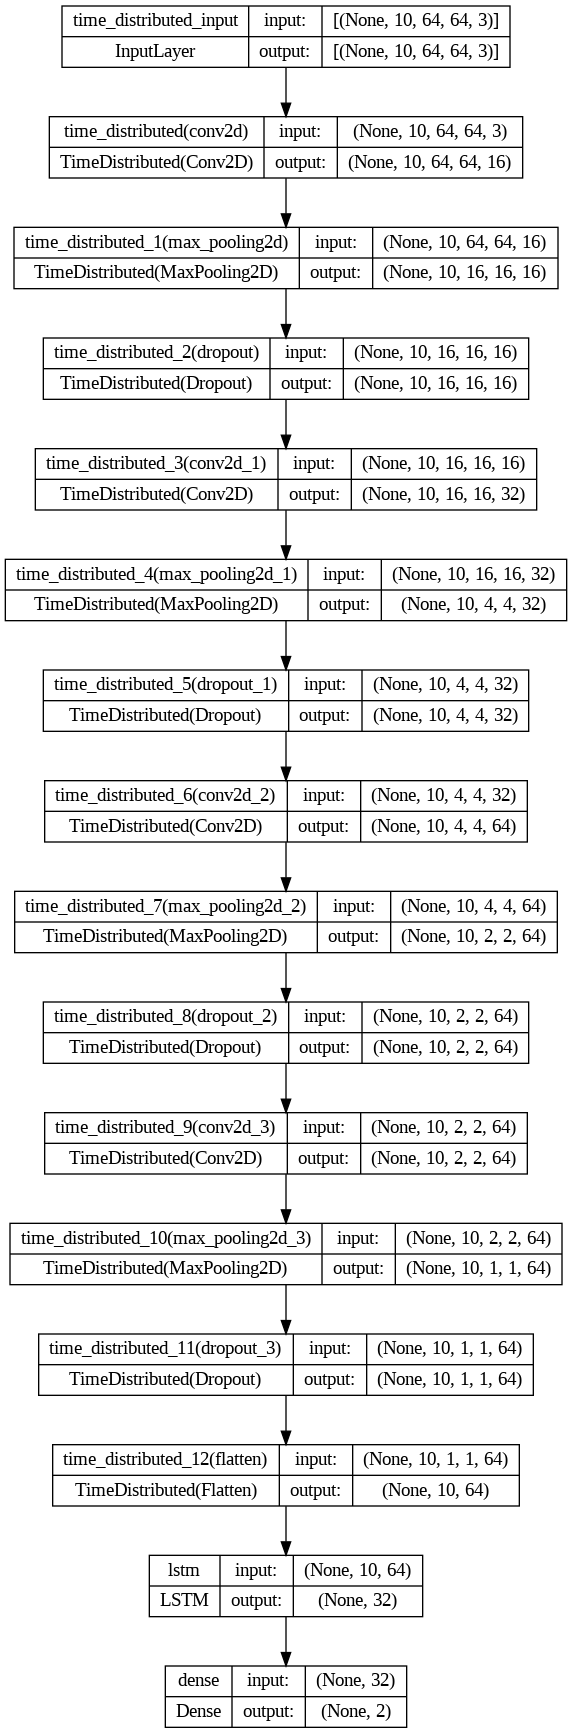

In [15]:
plot_model(LRCN_model, to_file="LRCN_model_sturcture_plot.png", show_shapes=True , show_layer_names=True)

In [20]:
early_stopping_callback= EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)
LRCN_model.compile(loss='categorical_crossentropy', optimizer ='Adam', metrics=["accuracy"])
LRCN_model_training_history=LRCN_model.fit(x=features_train,y=labels_train,epochs=70,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/70
300/300 [==============================] - 8s 10ms/step - loss: 0.0953 - accuracy: 0.9650 - val_loss: 0.3424 - val_accuracy: 0.8833
Epoch 2/70
300/300 [==============================] - 2s 8ms/step - loss: 0.0919 - accuracy: 0.9683 - val_loss: 0.4666 - val_accuracy: 0.8867
Epoch 3/70
300/300 [==============================] - 3s 9ms/step - loss: 0.0914 - accuracy: 0.9608 - val_loss: 0.4234 - val_accuracy: 0.8800
Epoch 4/70
300/300 [==============================] - 3s 9ms/step - loss: 0.0851 - accuracy: 0.9750 - val_loss: 0.5430 - val_accuracy: 0.8300
Epoch 5/70
300/300 [==============================] - 2s 8ms/step - loss: 0.0863 - accuracy: 0.9708 - val_loss: 0.5399 - val_accuracy: 0.8533
Epoch 6/70
300/300 [==============================] - 2s 8ms/step - loss: 0.1125 - accuracy: 0.9542 - val_loss: 0.4063 - val_accuracy: 0.8600
Epoch 7/70
300/300 [==============================] - 2s 8ms/step - loss: 0.0968 - accuracy: 0.9658 - val_loss: 0.4022 - val_accuracy: 0.8733
Epoch

In [22]:
model_evaluation_history=LRCN_model.evaluate(features_test,labels_test)

16/16 [==============================] - 0s 12ms/step - loss: 0.3872 - accuracy: 0.8820


In [25]:
model_evaluation_loss, model_evaluation_accuracy=model_evaluation_history
date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name=f'LRCN_model__Date_Time_Best3_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

In [ ]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

NameError: ignored

In [30]:
def predict_on_video(video_file_path, output_file_path,SEQUENCE_LENGTH):

  video_reader=cv2.VideoCapture(video_file_path)

  original_video_width=int (video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height=int (video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))



  video_writer=cv2.VideoWriter(output_file_path,cv2.VideoWriter_fourcc('M','P','4','V'),video_reader.get(cv2.CAP_PROP_FPS),(original_video_width,original_video_height))

  frames_queue=deque(maxlen=SEQUENCE_LENGTH)

  predicted_class_name=''

  while video_reader.isOpened():

    ok,frame=video_reader.read()

    if not ok:
      break

    resized_frame=cv2.resize(frame, (IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame=resized_frame/255

    frames_queue.append(normalized_frame)

    if len(frames_queue)==SEQUENCE_LENGTH:

      predicted_labels_probabilities=LRCN_model.predict(np.expand_dims(frames_queue,axis=0))[0]

      predicted_label=np.argmax(predicted_labels_probabilities)

      predicted_class_name=CLASSES_LIST[predicted_label]

    cv2.putText(frame,predicted_class_name,(10,20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    video_writer.write(frame)

  video_reader.release()
  video_writer.release()




In [41]:
def predict1_on_video(video_file_path, output_file_path,SEQUENCE_LENGTH):

  video_reader=cv2.VideoCapture(video_file_path)

  original_video_width=int (video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height=int (video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frames_list=[]

  predicted_class_name=''
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
    l=frame_counter * skip_frames_window
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, l)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame, (IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame=resized_frame/255

    frames_list.append(normalized_frame)
  predicted_labels_probabilities=LRCN_model.predict(np.expand_dims(frames_list,axis=0))[0]

  predicted_label=np.argmax(predicted_labels_probabilities)

  predicted_class_name=CLASSES_LIST[predicted_label]

  print(f'Action Predicted:{predicted_class_name}\nConfidence:{predicted_labels_probabilities[predicted_label]}')
  video_reader.release()



In [26]:
%%capture

!pip3  install yt-dlp



In [34]:


import yt_dlp


def download_youtube_videos(youtube_video_url,output_directory):

  video=yt_dlp.YoutubeDL().extract_info(url=youtube_video_url,download=False)

  title=video['title']

  video_best=video['formats'][0]

  output_file_path=f'{output_directory}/{title}.mp4'

  yt_dlp.YoutubeDL().download([youtube_video_url])

  return title

In [35]:

test_videos_directory='test_videos'
os.makedirs(test_videos_directory,exist_ok=True)
!yt-dlp -S res,ext:mp4:m4a --recode mp4 https://www.youtube.com/watch?v=BiqpH2PPv6w

video_tital=download_youtube_videos('https://www.youtube.com/watch?v=BiqpH2PPv6w',test_videos_directory)

input=f'{test_videos_directory}/{video_tital}.mp4'

[youtube] Extracting URL: https://www.youtube.com/watch?v=BiqpH2PPv6w
[youtube] BiqpH2PPv6w: Downloading webpage
[youtube] BiqpH2PPv6w: Downloading ios player API JSON
[youtube] BiqpH2PPv6w: Downloading android player API JSON
[youtube] BiqpH2PPv6w: Downloading m3u8 information
[info] BiqpH2PPv6w: Downloading 1 format(s): 609+140
[download] School Girls Fight 😬 😬 😬 [BiqpH2PPv6w].mp4 has already been downloaded
[VideoConvertor] Not converting media file "School Girls Fight 😬 😬 😬 [BiqpH2PPv6w].mp4"; already is in target format mp4
[youtube] Extracting URL: https://www.youtube.com/watch?v=BiqpH2PPv6w
[youtube] BiqpH2PPv6w: Downloading webpage
[youtube] BiqpH2PPv6w: Downloading ios player API JSON
[youtube] BiqpH2PPv6w: Downloading android player API JSON
[youtube] BiqpH2PPv6w: Downloading m3u8 information
[youtube] Extracting URL: https://www.youtube.com/watch?v=BiqpH2PPv6w
[youtube] BiqpH2PPv6w: Downloading webpage
[youtube] BiqpH2PPv6w: Downloading ios player API JSON
[youtube] BiqpH2PP

In [43]:
from moviepy.editor import VideoFileClip
output_video_file_path=f'{test_videos_directory}/{video_tital}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict1_on_video('/content/School Girls Fight 😬 😬 😬 [BiqpH2PPv6w].mp4',output_video_file_path,SEQUENCE_LENGTH)

video=VideoFileClip(output_video_file_path,audio=False,target_resolution=(300,None))

video.ipython_display()



1/1 [==============================] - 0s 42ms/step
Action Predicted:Violence
Confidence:0.8901031613349915
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [38]:
from moviepy.editor import VideoFileClip
output_video_file_path=f'{test_videos_directory}/{video_tital}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video('/content/V_104.mp4',output_video_file_path,SEQUENCE_LENGTH)

video=VideoFileClip(output_video_file_path,audio=False,target_resolution=(300,None))

video.ipython_display()


1/1 [==============================] - 0s 20ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  98%|█████████▊| 148/151 [00:00<00:00, 236.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/School Girls Fight 😬 😬 😬-Output-SeqLen10.mp4, 479700 bytes wanted but 0 bytes read,at frame 150/151, at time 5.00/5.01 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [42]:
from moviepy.editor import VideoFileClip
output_video_file_path=f'{test_videos_directory}/{video_tital}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict1_on_video('/content/V_104.mp4',output_video_file_path,SEQUENCE_LENGTH)

video=VideoFileClip(output_video_file_path,audio=False,target_resolution=(300,None))

video.ipython_display()

1/1 [==============================] - 1s 525ms/step
Action Predicted:Violence
Confidence:0.9997492432594299
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  93%|█████████▎| 140/151 [00:01<00:00, 119.93it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/School Girls Fight 😬 😬 😬-Output-SeqLen10.mp4, 479700 bytes wanted but 0 bytes read,at frame 150/151, at time 5.00/5.01 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4
